# TODO:

1. Find some good candidates for binary classification including ensembles
    1. 5 different models
2. Write a pipeline for testing and analysis of the results
3. Create code documentation :)
4. Maybe extract the functions to separate .py to make the notebook cleaner
3. Write the report
4. Prepare the presentation

# Imports and Consts

In [63]:
import pickle
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
from enum import Enum
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

## Generate parameters


In [64]:
# Get name of a variable as string
def namestr(obj, namespace) -> str:
    """Get name of a variable as a string"""
    return [name for name in namespace if namespace[name] is obj]

In [65]:
def generateParameters(arrays):
    """Takes any number of arrays and returns an array of dictionaries with keys as array names and values, all possible combinations"""

    allCombinations = list(itertools.product(*arrays))

    allCombinations = [list(elem) for elem in allCombinations]

    arrayNames = []

    for array in arrays:
        arrayNames.append(namestr(array, globals())[0])

    return [dict(zip(arrayNames, value)) for value in allCombinations]

- example usage, create arrays with parameters (their names should be the same as desired parameter names), pass them in an array to generateParamters function

In [66]:
arr1 = [1, 2, 7]
arr2 = [3, 4, 8]
generateParameters([arr1, arr2])

[{'arr1': 1, 'arr2': 3},
 {'arr1': 1, 'arr2': 4},
 {'arr1': 1, 'arr2': 8},
 {'arr1': 2, 'arr2': 3},
 {'arr1': 2, 'arr2': 4},
 {'arr1': 2, 'arr2': 8},
 {'arr1': 7, 'arr2': 3},
 {'arr1': 7, 'arr2': 4},
 {'arr1': 7, 'arr2': 8}]

## Model helpers

- definition of available models and feature selection methods

- getters for models and feature selection methods

In [67]:
class ModelType(Enum):
    """Available classifiers"""

    LDA = 0

    QDA = 1

    DecisionTree = 2

In [68]:
def getModel(modelType, arguments):
    """Returns a classifier that can fit() and predict()"""

    match modelType:

        case ModelType.LDA:

            return LinearDiscriminantAnalysis(**arguments)

        case ModelType.QDA:

            return QuadraticDiscriminantAnalysis(**arguments)

        case ModelType.DecisionTree:

            return DecisionTreeClassifier(**arguments)

In [69]:
class FeatureSelectorType(Enum):
    """Available Feature Selectors that can fit_transform() a dataset"""

    NoFeatureSelection = 0

    KBest = 1

In [70]:
class NoFeatureSelection:
    """Wrapper class for no feature selection, exposes fit_transform method that returns unchanged X"""

    def fit_transform(self, X, y):

        return X

In [71]:
def getFeatureSelector(selectorType, arguments):
    """Returns a feature selector that can fit_transform()"""

    match selectorType:

        case FeatureSelectorType.NoFeatureSelection:

            return NoFeatureSelection(**arguments)

        case FeatureSelectorType.KBest:

            return SelectKBest(**arguments)

## Experiment process

In [72]:
def getScore(y_true, y_pred, featuresUsed):
    """Get score based on y_true, y_pred and number of feature used

    Scoring function, based on which, the best model is selected.
    Score is calculated according to task description: +10 points for each
    correctly classified positive class, -200 points for each feature used
    """

    score = 0

    correct = 0

    for i, y in enumerate(y_true):
        if y == y_pred[i]:
            correct += 1

    score = 10 * correct - 200 * featuresUsed
    return score

In [73]:
def performExperiment(X_train, y_train, X_test, y_test, model):
    """Returns a score for given model and provided data"""

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    finalResult = getScore(y_test, y_pred, len(X_train[0]))

    # Take only 1000 of the highest class 1 probabilities

    # TODO: Turn it into a dataframe and keep track of the indexes

    # finalResult = np.sort(result[:, 1])[::-1][:1000]

    return finalResult

In [74]:
def conductExperiments(models, featureSelectors, X_orig, y_orig):
    """Collects score results for all provided models and feature selectors on given dataset

    Paramters:

    models: array in a format: [{"model":"model name","parameters":[{paramters object}]}]

    featureSelectors: array in a format: [{"model":"model name","parameters":[{paramters object}]}]


    """
    results = []
    for model in models:
        for modelParameters in model["parameters"]:

            for featureSelector in featureSelectors:
                for featureSelectorParameters in featureSelector["parameters"]:
                    selector = getFeatureSelector(
                        featureSelector["model"], featureSelectorParameters
                    )
                    X_new = selector.fit_transform(X_orig, y_orig)

                    X_split_train, X_split_test, y_split_train, y_split_test = (
                        train_test_split(X_new, y_orig, test_size=0.33, random_state=42)
                    )

                    result = performExperiment(
                        X_train=X_split_train,
                        y_train=y_split_train,
                        X_test=X_split_test,
                        y_test=y_split_test,
                        model=getModel(model["model"], modelParameters),
                    )

                    results.append(
                        [
                            result,
                            model["model"].name,
                            modelParameters,
                            featureSelector["model"].name,
                            featureSelectorParameters,
                        ]
                    )
    return results

## Results processing

In [111]:
def getParameterName(column, parameter):
    """Helper function returns a new name for parameter to avoid collisions"""
    return column + "_" + parameter

In [112]:
def extractParamterInformation(df, parameterColumnName, parameterName):
    """
    Extract information about certain parameter and include it with
    the dataframe as a separate column in a format parameterColumnName+"_"+parameterName
    to avoid conflicts between model parameters and feature selector parameters
    """

    df[getParameterName(parameterColumnName, parameterName)] = df.apply(
        lambda x: (
            x[parameterColumnName][parameterName]
            if parameterName in x[parameterColumnName].keys()
            else pd.NA
        ),
        axis=1,
    )

# Load Data

load the training and test data in a format specified by task description

In [76]:
with open("./Dataset/x_test.txt") as file:
    X_test = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/x_train.txt") as file:
    X_train = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/y_train.txt") as file:
    y_train = [[float(digit) for digit in line.split()] for line in file]

In the X_test there are 500 features and 5000 observations, y_train contains 5000 values, X_train contains 500 features and 5000 observations

In [77]:
print("X_test datapoints:", len(X_test), " features:", len(X_test[0]))
print("X_train datapoints:", len(X_train), " features:", len(X_train[0]))
print("y_train datapoints:", len(y_train))

X_test datapoints: 5000  features: 500
X_train datapoints: 5000  features: 500
y_train datapoints: 5000


# Experiment

## Parameters

In [124]:
# TODO: Create parameter arrays

# LDA
solver = ["svd", "lsqr"]
ldaParameters = generateParameters([solver])


models = [{"model": ModelType.LDA, "parameters": ldaParameters}]

In [125]:
score_func = [f_classif]
k = [5, 10, 20, 40, 80]
kBestParameters = generateParameters([score_func, k])

featureSelectors = [
    {"model": FeatureSelectorType.NoFeatureSelection, "parameters": [{}]},
    {"model": FeatureSelectorType.KBest, "parameters": kBestParameters},
]

## Conducting the experiment

In [126]:
y_train = np.ravel(y_train, order="C")

In [127]:
%%time
results = conductExperiments(
    models=models, featureSelectors=featureSelectors, X_orig=X_train, y_orig=y_train
)
with open("./Results/results", "wb") as f:
    pickle.dump(results, f)

CPU times: total: 4.67 s
Wall time: 3.62 s


# Results

In [128]:
with open(r"./Results/results", "rb") as input_file:
    results = pickle.load(input_file)

In [129]:
resultsDf = pd.DataFrame(
    results,
    columns=[
        "score",
        "model",
        "model_parameters",
        "feature_selector",
        "selector_parameters",
    ],
)

In [135]:
# Place here paramters you wish to investigate


parameterName = ["k"]
parameterColumnName = ["selector_parameters"]

parameters = generateParameters([parameterName, parameterColumnName])

# The same can be done for models, then the paramters array can be concatenated

parameterName = ["solver"]
parameterColumnName = ["model_parameters"]
parameters = parameters + generateParameters([parameterName, parameterColumnName])

In [136]:
for parameter in parameters:
    extractParamterInformation(resultsDf, **parameter)

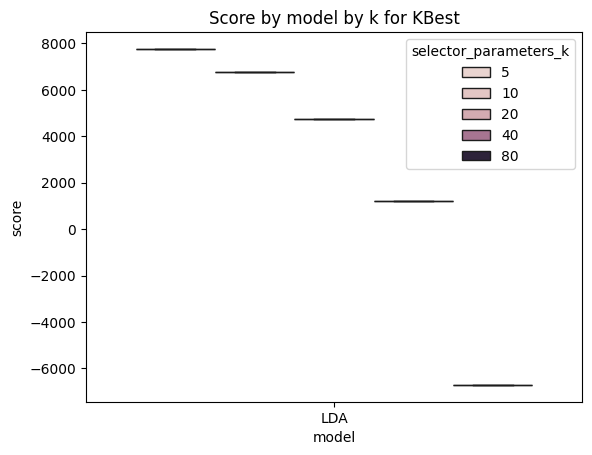

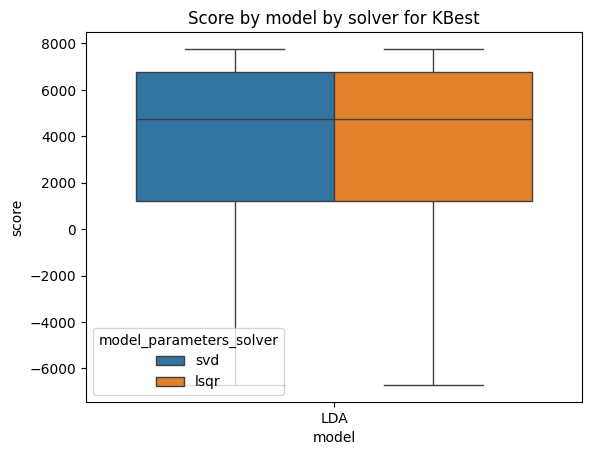

In [149]:
for parameter in parameters:
    grouped = resultsDf.groupby("feature_selector")
    for name, group in grouped:
        group = group.dropna()

        if group.shape[0] > 0:
            plt.title(
                "Score by model by " + str(parameter["parameterName"]) + " for " + name
            )
            sns.boxplot(
                data=group.reset_index(),
                x="model",
                y="score",
                hue=getParameterName(
                    parameter["parameterColumnName"], parameter["parameterName"]
                ),
            )
            plt.show()